In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline

### Make some helper functions

In [101]:
def MakeLabel(Treat):
    label = ''
    for level in Treat.index:
        label += str(Treat.ix[level]) + ' '
    return label

def MakeYearIndex(Year):
    GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for Fact in GraphTreats.columns:
        if len(GraphTreats.ix[:,Fact].drop_duplicates()) <=1:
            GraphTreats.drop(Fact,axis=1,inplace=True)
    return GraphTreats

def SetLineSymbols(Index):
    Colors = ['red','orange','blue','green','black','pink']
    Markers = ['o-','s-','^-','*-','+-','x-']
    Sizes = [12,10,8,6,4,2]
    Demarkers = [Colors, Markers, Sizes]
    DemarkerIndex = []
    FactorNumber = 0
    for Fact in Index.columns:
        LevelList = Index.ix[:,Fact].drop_duplicates().values
        FactorLevels = LevelList.size
        LevelDemarkers = Demarkers[FactorNumber][0:FactorLevels]
        LevelPairs = pd.Series(data=LevelDemarkers, index=LevelList)
        DemarkerIndex.append(LevelPairs)
        FactorNumber +=1
    return DemarkerIndex

def SetSymbols(Index):
    Colors = ['red','orange','blue','green']
    Markers = ['o','s','^','*','+','x']
    Sizes = [12,10,8,6,4,2]
    Demarkers = [Colors, Markers, Sizes]
    DemarkerIndex = []
    FactorNumber = 0
    for Fact in Index.columns:
        LevelList = Index.ix[:,Fact].drop_duplicates().values
        FactorLevels = LevelList.size
        LevelDemarkers = Demarkers[FactorNumber][0:FactorLevels]
        LevelPairs = pd.Series(data=LevelDemarkers, index=LevelList)
        DemarkerIndex.append(LevelPairs)
        FactorNumber +=1
    return DemarkerIndex

def FindAxisMax(DataArray):
    Max = np.percentile(pd.to_numeric(DataArray.dropna()),99)
    Exponent = np.power(10,len(str(int(Max))))
    return np.ceil(Max/Exponent*10)*Exponent/10

def FindAxisMin(DataArray):
    Min = np.percentile(pd.to_numeric(DataArray.dropna()),1)
    Exponent = np.power(10,len(str(int(Min))))
    return np.floor(Min/Exponent*10)*Exponent/10

def MakeSingleVariableRegression(XVar,YVar):
    Graph = plt.figure(figsize=(10,10))
    Yup = FindAxisMax(IndexedData.ix[:,YVar ])
    Ylow = FindAxisMin(IndexedData.ix[:,YVar ])
    Xup = FindAxisMax(IndexedData.ix[:,XVar ])
    Xlow = FindAxisMin(IndexedData.ix[:,XVar ])

    pos=1
    for Year in YearList:
        Ax = Graph.add_subplot(3,2,pos)
        Ax.spines['right'].set_visible(False)
        Ax.spines['top'].set_visible(False)
        plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
        plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
        GraphData = IndexedData.ix[IndexedData.YearSown==Year]
        GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
        for var in GraphTreats.columns:
            LevelList = GraphTreats.ix[:,var].drop_duplicates().values
            if LevelList.size <= 1:
                GraphTreats.drop(var,axis=1,inplace=True)
        Demarkers = SetSymbols(GraphTreats)
        for Treat in GraphTreats.index:
            Filter = GraphData.TrtNum == Treat
            XData = GraphData.ix[Filter,XVar]
            YData = GraphData.ix[Filter,YVar]
            col = Demarkers[0][GraphTreats.ix[Treat][0]]
            mark = Demarkers[1][GraphTreats.ix[Treat][1]]
            plt.plot(XData,YData,mark,color=col,markersize=12)
            plt.plot([Xlow,Xup],[Ylow,Yup],'--',color='k')
            plt.title(Year,fontsize = 20)
        plt.ylim(Ylow,Yup)
        plt.xlim(Xlow,Xup)
        Ax.set_xticks([Ax.get_xticks()[0],Ax.get_xticks()[-1]])
        Ax.set_yticks([Ax.get_yticks()[1],Ax.get_yticks()[-1]])
        if pos in [1,3]:
            plt.ylabel(YVar,fontsize=16)
        if pos in [2,3]:
            plt.xlabel(XVar,fontsize=16)
        pos+=1

def MakeHarvestVariableGraph(Variable):
    Graph = plt.figure(figsize=(10,10))
    pos=1
    TreatInLabel = pd.Series(index = YearList, data = [[1],[1],[0,2],[0,2],[0,2]])
    Yup = FindAxisMax(IndexedData.ix[:,Variable ])
    for Year in YearList:
        Pannel = Graph.add_subplot(len(YearList),1,pos)
        plt.ylim(0,Yup)
        plt.tick_params(labelsize=20)
        Pannel.tick_params(labelbottom='off')
        if Year == 2014:
            plt.ylabel(Variable, fontsize = 20)
        GraphData = pd.to_numeric(IndexedData[GS90Filter].ix[Year,Variable].dropna())
        MeanData = GraphData.groupby(GraphData.index).mean()
        Left = 0
        count = 0
        LastSowIndex = MeanData.index[count][0]
        for Treat in MeanData.index:
            SowLab = MeanData.index[count][0].to_datetime().strftime('%d-%b')
            if count == 0:
                plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
            if LastSowIndex != MeanData.index[count][0]:
                Left+=1
                plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
            plt.bar(left=Left+.5,height=MeanData[count],color='lightgrey')
            FullLab = MeanData.index[count][1:]
            forShort = TreatInLabel[Year]
            LabMembers = [FullLab[i] for i in forShort]
            Label = ''
            for member in LabMembers:
                Label += str(member)
                Label += '  '
            height = MeanData[count] * 0.95
            plt.text(Left+.7,height, Label,rotation=90, fontsize=10)
            Left += 1
            LastSowIndex = MeanData.index[count][0]
            count += 1
        pos +=1
        
def MakeTimeCoarseGraph(Year,Variable):
    GraphData = Data.ix[Data.YearSown==Year]
    GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for var in GraphTreats.columns:
            LevelList = GraphTreats.ix[:,var].drop_duplicates().values
            if LevelList.size <= 1:
                GraphTreats.drop(var,axis=1,inplace=True)
    Demarkers = SetLineSymbols(GraphTreats)
    Graph = plt.figure(figsize=(8,6))

    for Treat in GraphTreats.index:
        Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
        GraphData = Data.ix[Filter,Variable].dropna().groupby(level='SampleDate').mean()
        col = Demarkers[0][GraphTreats.ix[Treat][0]]
        mark = Demarkers[1][GraphTreats.ix[Treat][1]]
        try:
            size = Demarkers[2][GraphTreats.ix[Treat][2]]
        except:
            size = 8
        plt.plot(GraphData,mark,color = col, markersize = size,label = MakeLabel(GraphTreats.ix[Treat,:]))
    plt.xticks(rotation=45)
    plt.ylabel(Variable,fontsize=12)
    plt.tick_params(labelsize=16)
    plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
    
def MakeThermalTimeCoarseGraphWithGS(Variable,GSsToGraph,YearsToGraph):
    Colors = ['red','orange','blue','green']
    Markers = ['o-','s-','^-','*-']
    Markers2 = ['o','s','^','*']
    Sizes = [12,10,8,6,4,2]
    Graph = plt.figure(figsize=(12,16))
    YearPos = 0
    for Year in YearsToGraph:
        filter = Data.ix[:,'YearSown'] == Year
        SowDates = pd.to_datetime(Data.ix[filter,'SowingDate'].drop_duplicates().values)
        TreatPos = 0
        Graph.add_subplot(3,1,YearPos+1)
        for Treat in SowDates:
            Filter = (Data.YearSown == Year) & (Data.SowingDate == Treat) & (Data.Cultivar == 'Wakanui')  & (Data.PlantPopn==200)
            GraphData = pd.to_numeric(Data.ix[Filter,Variable].dropna()).groupby(level='SampleDate').mean()
            TtFromSow = pd.to_numeric(Data.ix[Filter,'TtFromSowing'].ix[GraphData.index].dropna()).groupby(level='SampleDate').mean()
            plt.plot(TtFromSow,GraphData,Markers[YearPos],color = Colors[TreatPos], markersize = 8)
            subfilter = (Data.ix[:,'YearSown'] == Year) & (Data.ix[:,'SowingDate']==Treat)
            Date =  Data.ix[subfilter,'GS65'].dropna().drop_duplicates()
            if len(GSsToGraph)>0:
                TtatSow = Data.ix[subfilter,'TTAtSow'].drop_duplicates()
                TTSowTo65 = MetData.ix[Date,'Tt'].values[0]-TtatSow.values[0]
                TTSowTo32 = TTSowTo65 - Post32ZadocModel.ix[Post32ZadocModel.Zstage==65,'TTsinceGS32'].values[0]
                TTSowTo45 = TTSowTo65 - Post32ZadocModel.ix[Post32ZadocModel.Zstage==45,'TTsinceGS32'].values[0]
                plt.plot([TTSowTo32,TTSowTo32],[1.1,0.0],Markers[YearPos],color = Colors[TreatPos], markersize = 8)
            TreatPos +=1
        YearPos+=1
    plt.xticks(rotation=45)
    plt.ylabel(Variable,fontsize=12)
    plt.tick_params(labelsize=16)
    plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)
    
def MakeThermalTimeCoarseGraph(Variable,YearsToGraph):
    Colors = ['red','orange','blue','green']
    Markers = ['o-','s-','^-','*-']
    Markers2 = ['o','s','^','*']
    Sizes = [12,10,8,6,4,2]
    Graph = plt.figure(figsize=(12,16))
    YearPos = 0
    for Year in YearsToGraph:
        GraphData = Data.ix[Data.YearSown==Year]
        GraphTreats = MakeYearIndex(Year)
        Demarkers = SetLineSymbols(GraphTreats)
        filter = Data.ix[:,'YearSown'] == Year
        SowDates = pd.to_datetime(Data.ix[filter,'SowingDate'].drop_duplicates().values)
        TreatPos = 0
        Graph.add_subplot(3,1,YearPos+1)
        for Treat in SowDates:
            Filter = (Data.YearSown == Year) & (Data.SowingDate == Treat) #& (Data.Cultivar == 'Wakanui')  & (Data.PlantPopn==200)
            GraphData = pd.to_numeric(Data.ix[Filter,Variable].dropna()).groupby(level='SampleDate').mean()
            TtFromSow = pd.to_numeric(Data.ix[Filter,'TtFromSowing'].ix[GraphData.index].dropna()).groupby(level='SampleDate').mean()
            plt.plot(TtFromSow,GraphData,Markers[YearPos],color = Colors[TreatPos], markersize = 8)
            subfilter = (Data.ix[:,'YearSown'] == Year) & (Data.ix[:,'SowingDate']==Treat)
            TreatPos +=1
        YearPos+=1
    plt.xticks(rotation=45)
    plt.ylabel(Variable,fontsize=12)
    plt.tick_params(labelsize=16)
    plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

### Bring in the Crop Data

In [3]:
#Data = pd.read_excel('Data compilation updated.xlsx',sheetname='DataCompiled',skiprows=[0,1,2])
#Data.to_pickle('AllData.pkl')
Data = pd.read_pickle('AllData.pkl')

### Set up some index objects

In [4]:
TreatmentList = Data.TrtNum.drop_duplicates().values
print('TreatmentList')
print(TreatmentList)
YearList = Data.YearSown.drop_duplicates().values
print('YearList')
print(YearList)
Factors = ['Cultivar','SowingDate','PlantPopn','PGRCanopyMgmtTrt']

MetaIndex = pd.MultiIndex.from_product([YearList, TreatmentList])
GrandIndex = pd.DataFrame(index = MetaIndex, columns = Factors)
GrandIndex.sort_index(inplace=True)

print('Null Combos')
for Year in YearList:
    for Treat in TreatmentList:
        Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
        Indicies = Data.ix[Filter,Data.columns.isin(Factors)].drop_duplicates().values
        try:
            GrandIndex.ix[(Year,Treat)] = Indicies
        except:
            print(str(Year)+' '+str(Treat))

GrandIndex.dropna(how='all',inplace=True)

for Treat in GrandIndex.index:
    GrandIndex.ix[Treat,'SowingDate'] = GrandIndex.ix[Treat,'SowingDate'].to_datetime()

TreatmentList
[u'2a' u'2e' u'1a' u'1e' u'3a' u'3e' u'2c' u'1c' u'3c' u'1d' u'1b' u'2f'
 u'2d' u'2b' u'3b' u'3d' u'4a' u'4d' u'4b' u'4c']
YearList
[2013 2014 2015 2016 2017]
Null Combos
2013 4a
2013 4d
2013 4b
2013 4c
2014 2e
2014 1e
2014 3e
2014 2f
2015 2e
2015 1e
2015 3e
2015 2f
2016 2e
2016 1e
2016 3e
2016 2f
2017 2e
2017 1e
2017 3e
2017 2f
2017 4a
2017 4d
2017 4b
2017 4c


### Make a data frame of zero values on sowing date

In [5]:
ValuesToZero = ['LeafNum',
'NumLeafTips',
'NumLigules',
'PercentSenescence',
'NumGreenLeaves',
'NumSenescingLeaves',
'NumDeadLeaves',
'TotalBiomass',
'TotalLeafBiomass',
'GreenLeafBiomass',
'DeadLeafBiomass',
'LAI',
'CorrLightInterception',
'CorrLAI',
'NDVI',
'NDVIHC',
'WDVI',
'NDVISC']

ZeroData = pd.DataFrame(index = GrandIndex.index, columns = Data.columns)
for treat in ZeroData.index:
    ZeroData.ix[treat,'SampleDate'] = GrandIndex.ix[treat,'SowingDate']
    ZeroData.ix[treat,'Cultivar'] = GrandIndex.ix[treat,'Cultivar']
    ZeroData.ix[treat,'SowingDate'] = GrandIndex.ix[treat,'SowingDate']
    ZeroData.ix[treat,'PlantPopn'] = GrandIndex.ix[treat,'PlantPopn']
    ZeroData.ix[treat,'PGRCanopyMgmtTrt'] = GrandIndex.ix[treat,'PGRCanopyMgmtTrt']
    ZeroData.ix[treat,'YearSown'] = treat[0]
    ZeroData.ix[treat,'TrtNum'] = treat[1]
    for val in ValuesToZero:
        ZeroData.ix[treat,val] = 0.0
for val in ValuesToZero:
    ZeroData.ix[:,val] = pd.to_numeric(ZeroData.ix[:,val])
ZeroData.reset_index(level=[0,1],inplace=True,drop=True)

### Join the zero values with the observations and index the data

In [6]:
Data = Data.append(ZeroData)
Data.set_index('SampleDate',inplace=True,drop=False)
Data.sort_values(by='SowingDate',inplace=True)

### Add Truncated Sowing date into index and sort

In [7]:
for Treat in GrandIndex.index:
    GrandIndex.ix[Treat,'SowingDate'] = GrandIndex.ix[Treat,'SowingDate'].strftime('%d-%b')

TreatmentOrder = ['SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt']
GrandIndex = GrandIndex[TreatmentOrder]

### Bring in the Met data and calculate a few variables

In [22]:
MetData = pd.read_csv('.\Weather\LincolnClean.met',sep='\t')
MetData.set_index('Date', inplace=True)
MetData.index = MetData.index.to_datetime()
MetData.ix[:,'MeanT'] = np.divide(np.add(MetData.ix[:,'MinT'],MetData.ix[:,'MaxT']),2)
MetData.ix[:,'Tt'] = MetData.ix[:,'MeanT'].cumsum()

In [23]:
for Year in YearList:
    filter = Data.ix[:,'YearSown']==Year
    if Year == 2013:
        FirstNDVI = dt.datetime(2013,05,28)
        LastNDVI = dt.datetime(2013,10,01)
        filter2 = filter & ((Data.SampleDate < FirstNDVI) | (Data.SampleDate > LastNDVI))
        Data.ix[filter2,'I/Io'] = Data.ix[filter2,'CorrLightInterception']
        filter3 = filter & (Data.SampleDate >= FirstNDVI) & (Data.SampleDate <= LastNDVI)
        Data.ix[filter3,'I/Io'] = Data.ix[filter3,'NDVISC']
    else:
        Data.ix[filter,'I/Io'] = Data.ix[filter,'NDVISC']

## Calculate Thermal time after sowing for each sampling date

In [25]:
for Year in YearList:
    filter = Data.ix[:,'YearSown'] == Year
    SowDates = pd.to_datetime(Data.ix[filter,'SowingDate'].drop_duplicates().values)
    for Sow in SowDates:
        subfilter = (Data.ix[:,'YearSown'] == Year) & (Data.ix[:,'SowingDate']==Sow)
        Data.ix[subfilter,'TTAtSow'] = MetData.ix[Sow,'Tt']        
Data.ix[:,'TtAtSample'] = [MetData.ix[X,'Tt'] for X in Data.index]
Data.ix[:,'TtFromSowing'] = Data.ix[:,'TtAtSample'] - Data.ix[:,'TTAtSow']

### Make a Dataframe for simple biomass model and interpolate Cover values into it

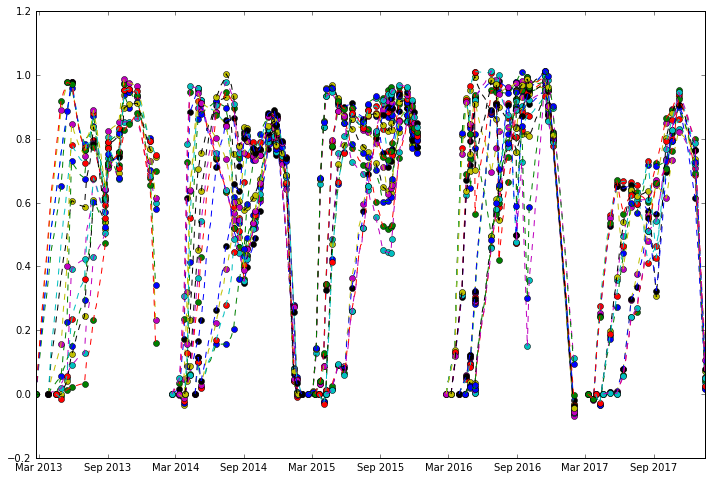

In [112]:
Graph = plt.figure(figsize=(12,8))
VarToInt = 'I/Io'#'NDVISC'
InterpolationIndex = pd.MultiIndex.from_product([YearList,TreatmentList,MetData.ix['2013-02-01':].index], names=['year', 'TrtNum', 'Date'])
BiomassAnalysis = pd.DataFrame(index = InterpolationIndex, columns=[VarToInt])
for Year in [2013,2014,2015,2016,2017]:
    YearData = Data.ix[Data.YearSown==Year,:]
    YearIndex = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for Treat in YearIndex.index:
        Filter = YearData.TrtNum == Treat
        TreatCover = YearData.ix[Filter,VarToInt].dropna().groupby(level='SampleDate').mean()
        plt.plot(TreatCover,'o')
        Dates = TreatCover.index
        ArrayTt = MetData.ix[Dates,'Tt']
        InterpDates = MetData.ix[Dates.min():Dates.max()].index
        dailyTt = MetData.ix[InterpDates,'Tt']
        InterpCover = np.interp(dailyTt,ArrayTt,TreatCover)
        TreatIndex = pd.MultiIndex.from_product([Year,Treat,InterpDates],names=['Year', 'TrtNum', 'Date'])
        InterpDF = pd.DataFrame(index = TreatIndex, data=InterpCover,columns=[VarToInt])
        plt.plot(InterpDates, InterpDF.ix[:,VarToInt],'--')
        BiomassAnalysis.update(InterpDF)

In [113]:
BiomassAnalysis

I/Io
year TrtNum Date           
2013 2a     2013-02-01  NaN
            2013-02-02  NaN
            2013-02-03  NaN
            2013-02-04  NaN
            2013-02-05  NaN
            2013-02-06  NaN
            2013-02-07  NaN
            2013-02-08  NaN
            2013-02-09  NaN
            2013-02-10  NaN
            2013-02-11  NaN
            2013-02-12  NaN
            2013-02-13  NaN
            2013-02-14  NaN
            2013-02-15  NaN
            2013-02-16  NaN
            2013-02-17  NaN
            2013-02-18  NaN
            2013-02-19  NaN
            2013-02-20  NaN
            2013-02-21  NaN
            2013-02-22  NaN
            2013-02-23  NaN
            2013-02-24  NaN
            2013-02-25  NaN
            2013-02-26  NaN
            2013-02-27  NaN
            2013-02-28  NaN
            2013-03-01  NaN
            2013-03-02  NaN
...                     ...
2017 4c     2018-04-15  NaN
            2018-04-16  NaN
            2018-04-17  NaN
            2018-04-18  NaN
            2018-04-19  NaN
            2018-04-20  NaN
            2018-04-21  NaN
            2018-04-22  NaN
            2018-04-23  NaN
            2018-04-24  NaN
            2018-04-25  NaN
            2018-04-26  NaN
            2018-04-27  NaN
            2018-04-28  NaN
            2018-04-29  NaN
            2018-04-30  NaN
            2018-05-01  NaN
            2018-05-02  NaN
            2018-05-03  NaN
            2018-05-04  NaN
            2018-05-05  NaN
            2018-05-06  NaN
            2018-05-07  NaN
            2018-05-08  NaN
            2018-05-09  NaN
            2018-05-10  NaN
            2018-05-11  NaN
            2018-05-12  NaN
            2018-05-13  NaN
            2018-05-14  NaN

[192900 rows x 1 columns]

### Implement simple biomass model

In [28]:
BiomassAnalysis.dropna(inplace=True)
BiomassAnalysis.sort_index(inplace=True)
for Year in [2013,2014,2015,2016,2017]:
    YearData = Data.ix[Data.YearSown==Year,:]
    YearIndex = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for Treat in YearIndex.index:
        Rad = MetData.ix[BiomassAnalysis.ix[(Year,Treat),:].index,'Radn']
        Temp = MetData.ix[BiomassAnalysis.ix[(Year,Treat),:].index,'MeanT']
        BiomassAnalysis.ix[(Year,Treat),'Radn'] = Rad.values
        BiomassAnalysis.ix[(Year,Treat),'Temp'] = Temp.values
BiomassAnalysis.ix[:,'IntRadn'] = BiomassAnalysis.ix[:,VarToInt] * BiomassAnalysis.ix[:,'Radn']
XTemp = [-10,0,15,25,35]
YRUE = [0,0,15,15,0]
BiomassAnalysis.ix[:,'RUE'] = [np.interp(BiomassAnalysis.ix[x,'Temp'],XTemp,YRUE) for x in BiomassAnalysis.index]
BiomassAnalysis.ix[:,'PotDM'] = BiomassAnalysis.ix[:,'RUE'] * BiomassAnalysis.ix[:,'IntRadn']

TreatsWithIncompleteRadnData = [(2013,'1b'),(2013,'2b'),(2013,'3b'),
                               (2013,'1d'),(2013,'2d'),(2013,'3d'),
                                (2013,'2f'),
                               (2015,'4d')]
for Incomplete in TreatsWithIncompleteRadnData:
    BiomassAnalysis.ix[Incomplete,:] = np.nan

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


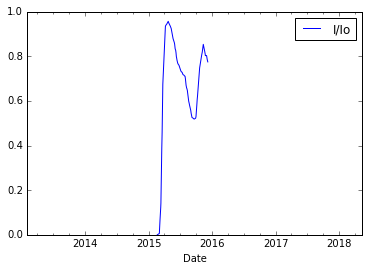

In [114]:
BiomassAnalysis.ix[(2015,'1a')].plot()

## Graph Zadoc stage againts TT since sowing for 2014 where we have good data

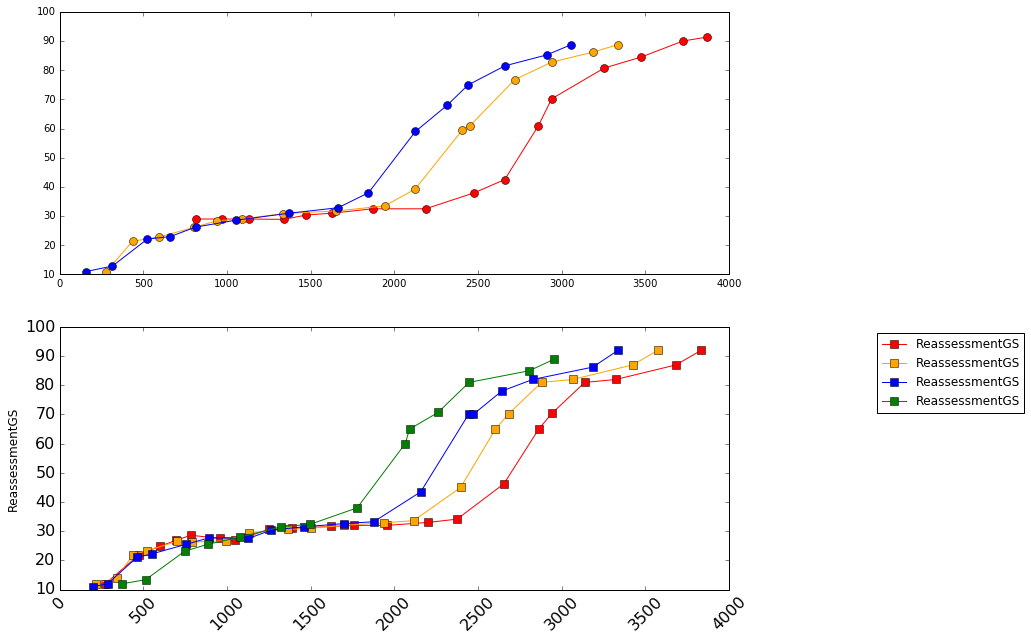

In [29]:
Variable = 'ReassessmentGS'
MakeThermalTimeCoarseGraph(Variable,[2013,2014])

## Following GS32 the sowing dates appear to have a similar pattern.  The differences in time to GS32 are related to final leaf number and these can be offset.  Lets look at leaf numbers first for 2014 where zadoc data is best

### First sow date had 17 leaves, then 15.5, 14.5, and 13 leaves for the final sow date.  All of these leaves will be appearing with a large phyllochron and this many phyllochrons can be removed to align the zadoc data post stage 32 for model fitting.

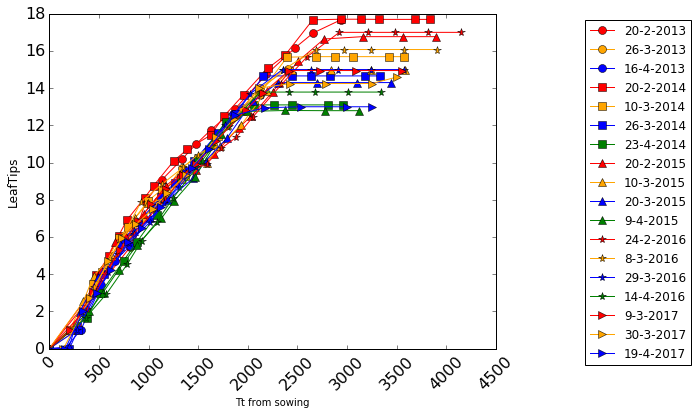

In [70]:
Colors = ['red','orange','blue','green']
Markers = ['o-','s-','^-','*-','>-']
Sizes = [12,10,8,6,4,2]
Graph = plt.figure(figsize=(8,6))
YearPos = 0
for Year in YearList:
    Filter = Data.ix[:,'YearSown'] == Year
    SowDates = pd.to_datetime(Data.ix[Filter,'SowingDate'].drop_duplicates().values)
    TreatPos = 0
    for Treat in SowDates:
        Filter = (Data.YearSown == Year) & (Data.SowingDate == Treat) & (Data.Cultivar == 'Wakanui')  & ((Data.PlantPopn==200) | (Data.PlantPopn==50) |(Data.PlantPopn==150)) & (Data.PGRCanopyMgmtTrt == 'Normal')
        GraphData = pd.to_numeric(Data.ix[Filter,'NumLigules'].dropna()).groupby(level='SampleDate').mean()
        TtFromSow = pd.to_numeric(Data.ix[Filter,'TtFromSowing'].ix[GraphData.index].dropna()).groupby(level='SampleDate').mean()
        plt.plot(TtFromSow,GraphData,Markers[YearPos],color = Colors[TreatPos], markersize = 8,label = str(Treat.day)+'-'+str(Treat.month)+'-'+str(Treat.year))
        TreatPos +=1
    YearPos+=1
plt.xticks(rotation=45)
plt.ylabel('LeafTips',fontsize=12)
plt.xlabel('Tt from sowing')
plt.tick_params(labelsize=16)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

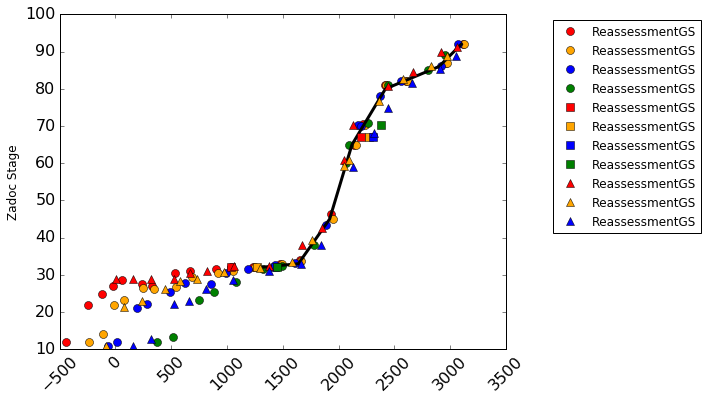

In [71]:
Colors = ['red','orange','blue','green']
phyllochron = 180
ExtraLeaves = [4,2.5,1.5,0]
Offsets = np.multiply(ExtraLeaves,phyllochron)
Graph = plt.figure(figsize=(8,6))
YearPos = 0
filter = Data.ix[:,'YearSown'] == 2014
SowDates = pd.to_datetime(Data.ix[filter,'SowingDate'].drop_duplicates().values)
TreatPos = 0
for Treat in SowDates:
    Filter = (Data.YearSown == 2014) & (Data.SowingDate == Treat) 
    GraphData = pd.to_numeric(Data.ix[Filter,'ReassessmentGS'].dropna()).groupby(level='SampleDate').mean()
    TtFromSow = pd.to_numeric(Data.ix[Filter,'TtFromSowing'].ix[GraphData.index].dropna()).groupby(level='SampleDate').mean() 
    TtFrom32 = np.subtract(TtFromSow, Offsets[TreatPos])
    plt.plot(TtFrom32,GraphData,'o',color = Colors[TreatPos], markersize = 8)
    TreatPos +=1
YearPos+=1
plt.xticks(rotation=45)
plt.ylabel('Zadoc Stage',fontsize=12)
plt.tick_params(labelsize=16)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

#Model to quantify development post GS32
OffsetTtSowing = [1300, 1640, 1920, 2120, 2420, 2900, 3100]
Zstage = [32, 33, 45, 65, 80, 86, 92]

plt.plot(OffsetTtSowing,Zstage,'-',color='k',Linewidth=3)

ExtraLeaves = [4,2.5,1.5,0]
Offsets = np.multiply(ExtraLeaves,phyllochron)
YearPos = 0
filter = Data.ix[:,'YearSown'] == 2015
SowDates = pd.to_datetime(Data.ix[filter,'SowingDate'].drop_duplicates().values)
TreatPos = 0
for Treat in SowDates:
    Filter = (Data.YearSown == 2015) & (Data.SowingDate == Treat) 
    GraphData = pd.to_numeric(Data.ix[Filter,'ReassessmentGS'].dropna()).groupby(level='SampleDate').mean()
    TtFromSow = pd.to_numeric(Data.ix[Filter,'TtFromSowing'].ix[GraphData.index].dropna()).groupby(level='SampleDate').mean() 
    TtFrom32 = np.subtract(TtFromSow, Offsets[TreatPos])
    plt.plot(TtFrom32,GraphData,'s',color = Colors[TreatPos], markersize = 8)
    TreatPos +=1
YearPos+=1
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

ExtraLeaves = [4.5,2,0]
Offsets = np.multiply(ExtraLeaves,phyllochron)
YearPos = 0
filter = Data.ix[:,'YearSown'] == 2013
SowDates = pd.to_datetime(Data.ix[filter,'SowingDate'].drop_duplicates().values)
TreatPos = 0
for Treat in SowDates:
    Filter = (Data.YearSown == 2013) & (Data.SowingDate == Treat) 
    GraphData = pd.to_numeric(Data.ix[Filter,'ReassessmentGS'].dropna()).groupby(level='SampleDate').mean()
    TtFromSow = pd.to_numeric(Data.ix[Filter,'TtFromSowing'].ix[GraphData.index].dropna()).groupby(level='SampleDate').mean() 
    TtFrom32 = np.subtract(TtFromSow, Offsets[TreatPos])
    plt.plot(TtFrom32,GraphData,'^',color = Colors[TreatPos], markersize = 8)
    TreatPos +=1
YearPos+=1
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

### Now we have a model to interpolate zadox stage from a given date, package it into a data frame

In [72]:
Post32ZadocModel = pd.DataFrame(columns = ['TTsinceGS32','Zstage'])
Post32ZadocModel.TTsinceGS32 = np.subtract(OffsetTtSowing,OffsetTtSowing[0])
Post32ZadocModel.Zstage = Zstage

# Make a dataframe with indexing needed for doing harvest summary and determine crop specific variables

In [73]:
Index = ['YearSown','SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt']
IndexedData = Data.set_index(Index,drop=False)
IndexedData.sort_index(inplace=True)
#Make filters for selecting specific sample timings
GS32Filter = (IndexedData.ix[:,'SampleGS']=='GS32').values
GS65Filter = (IndexedData.ix[:,'SampleGS']=='GS65').values
GS90Filter = (IndexedData.ix[:,'SampleGS']=='GS90').values
#Calculate Anthesis parameters
IndexedData.ix[GS90Filter,'AnthesisStem'] = IndexedData.ix[GS65Filter,'StemBiomass']
IndexedData.ix[GS90Filter, 'AnthesisBiomass'] = IndexedData.ix[GS65Filter,'TotalBiomass']                                     
IndexedData.ix[GS90Filter,'GrainsPerGramStem'] = IndexedData.ix[GS90Filter,'GrainsMSq']/(IndexedData.ix[GS65Filter,'StemBiomass']/10)
IndexedData.ix[GS90Filter,'1000GrainWt0Pc'] = IndexedData.ix[GS90Filter,'ThousandGrainWeight'] * (100-IndexedData.ix[GS90Filter,'GrainMoisture'])/100

## Determine exact dates for GS32, 65 and 90 from the Zadoc Tt model defined above

In [74]:
TTat65 = np.interp(65,Post32ZadocModel.Zstage,Post32ZadocModel.TTsinceGS32)
TTat90 = np.interp(90,Post32ZadocModel.Zstage,Post32ZadocModel.TTsinceGS32)
TT65to90 = TTat90 - TTat65
for plot in IndexedData.ix[GS65Filter].index:
    GSAtSample = IndexedData.ix[GS65Filter].ix[plot].ReassessmentGS.mean()
    TTatObsDate = np.interp(GSAtSample,Post32ZadocModel.Zstage,Post32ZadocModel.TTsinceGS32)
    TTAdjust = TTat65 - TTatObsDate
    TTSowTo65 = TTAdjust + IndexedData.ix[GS65Filter].ix[plot].TtFromSowing.mean()
    TTSowTo90 = TTSowTo65 + TT65to90
    TTSowTo32 = TTSowTo65 - TTat65
    AccumTTatSow = IndexedData.ix[GS65Filter].ix[plot].TTAtSow.mean()
    AccumTTat32 = AccumTTatSow + TTSowTo32
    AccumTTat65 = AccumTTatSow + TTSowTo65
    AccumTTat90 = AccumTTatSow + TTSowTo90
    Filter = MetData.Tt == min(MetData.Tt, key=lambda x:abs(x-AccumTTat32))
    IndexedData.ix[plot,'GS32'] = MetData.ix[Filter].index[0]
    Filter = MetData.Tt == min(MetData.Tt, key=lambda x:abs(x-AccumTTat65))
    IndexedData.ix[plot,'GS65'] = MetData.ix[Filter].index[0]
    Filter = MetData.Tt == min(MetData.Tt, key=lambda x:abs(x-AccumTTat90))
    IndexedData.ix[plot,'GS90'] = MetData.ix[Filter].index[0]

### Calculate stage specific met variables

In [75]:
for Year in YearList:
    for Treat in TreatmentList:
        try:
            StartWinter = dt.datetime(Year,05,01)
            filter = (IndexedData.TrtNum == Treat) & (IndexedData.YearSown == Year)
            SowDate = IndexedData.ix[filter,'SowingDate'].dropna().drop_duplicates()[0]
            GS32Date = IndexedData.ix[filter,'GS32'].dropna().drop_duplicates()[0]
            GS65Date = IndexedData.ix[filter,'GS65'].dropna().drop_duplicates()[0]
            GS90Date = IndexedData.ix[filter,'GS90'].dropna().drop_duplicates()[0]
            RadInt = BiomassAnalysis.ix[(Year,Treat)].ix[SowDate:GS32Date].IntRadn.sum()
            Temp = BiomassAnalysis.ix[(Year,Treat)].ix[SowDate:GS32Date].Temp.mean()
            TempSum = BiomassAnalysis.ix[(Year,Treat)].ix[SowDate:GS32Date].Temp.sum()
            IndexedData.ix[filter,'VegRadn'] = RadInt
            IndexedData.ix[filter,'VegTemp'] = Temp
            IndexedData.ix[filter,'VegPTQ'] = RadInt/TempSum
            RadInt = BiomassAnalysis.ix[(Year,Treat)].ix[GS32Date:GS65Date].IntRadn.sum()
            Temp = BiomassAnalysis.ix[(Year,Treat)].ix[GS32Date:GS65Date].Temp.mean()
            TempSum = BiomassAnalysis.ix[(Year,Treat)].ix[GS32Date:GS65Date].Temp.sum()
            IndexedData.ix[filter,'GrainDevRadn'] = RadInt
            IndexedData.ix[filter,'GrainDevTemp'] = Temp
            IndexedData.ix[filter,'GrainDevPTQ'] = RadInt/TempSum
            RadInt = BiomassAnalysis.ix[(Year,Treat)].ix[GS65Date:GS90Date].IntRadn.sum()
            Temp = BiomassAnalysis.ix[(Year,Treat)].ix[GS65Date:GS90Date].Temp.mean()
            TempSum = BiomassAnalysis.ix[(Year,Treat)].ix[GS65Date:GS90Date].Temp.sum()
            IndexedData.ix[filter,'GrainFillRadn'] = RadInt
            IndexedData.ix[filter,'GrainFillTemp'] = Temp
            IndexedData.ix[filter,'GrainFillPTQ'] = RadInt/TempSum
            RadInt = BiomassAnalysis.ix[(Year,Treat)].ix[StartWinter:GS32Date].IntRadn.sum()
            Radn = MetData.Radn.ix[StartWinter:GS32Date].sum()
            Temp = MetData.MeanT.ix[StartWinter:GS32Date].mean()
            Rain = MetData.Rain.ix[StartWinter:GS32Date].sum()
            IndexedData.ix[filter,'WinterRadn'] = RadInt
            IndexedData.ix[filter,'WinterRadnTot'] = Radn
            IndexedData.ix[filter,'WinterTemp'] = Temp
            IndexedData.ix[filter,'WinterRain'] = Rain
        except:
            print(str(Year)+' '+str(Treat))
        

2013 1d
2013 1b
2013 2f
2013 2d
2013 2b
2013 3b
2013 3d
2013 4a
2013 4d
2013 4b
2013 4c
2014 2e
2014 1e
2014 3e
2014 2f
2015 2e
2015 1e
2015 3e
2015 2c
2015 1c
2015 3c
2015 1d
2015 2f
2015 2d
2015 3d
2015 4d
2015 4c
2016 2e
2016 1e
2016 3e
2016 2f
2017 2e
2017 1e
2017 3e
2017 2f
2017 4a
2017 4d
2017 4b
2017 4c


In [20]:
IndexedData.columns

Index([              u'TrialCode',                u'YearSown',
                        u'Farmer',                u'Location',
                          u'Plot',           u'TrialCodePlot',
                        u'TrtNum',                   u'Block',
                      u'Cultivar',              u'SowingDate',
                     u'PlantPopn',                  u'PGRTrt',
                     u'PGRTiming',        u'PGRCanopyMgmtTrt',
                          u'NTrt',              u'SampleDate',
                      u'ApproxGS',                u'SampleGS',
                u'ReassessmentGS',                u'PlantNum',
                       u'LeafNum',             u'NumLeafTips',
                    u'NumLigules',                   u'ttFeb',
                         u'ttMar',                   u'ttApr',
               u'LeafPositionNum',            u'LeafPosition',
                    u'AvLeafSize',            u'AvLeafWeight',
                         u'AvSLA',       u'PercentSenes

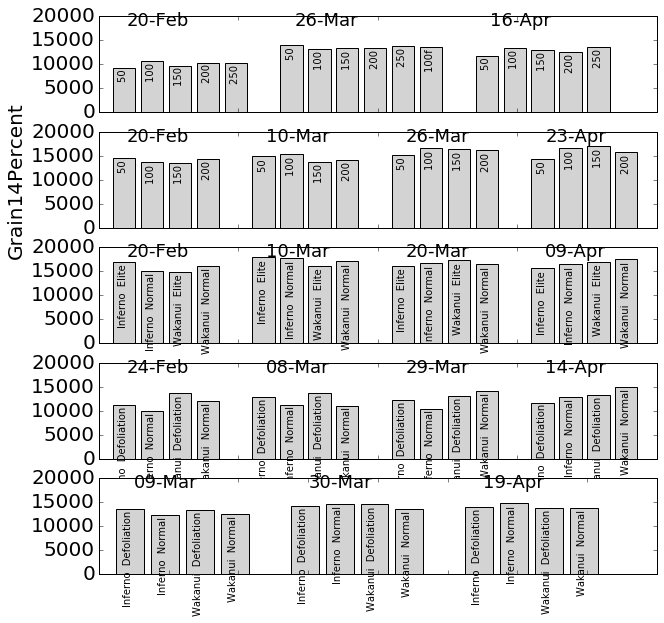

In [92]:
Variable = 'Grain14Percent'
Graph = plt.figure(figsize=(10,10))
pos=1
TreatInLabel = pd.Series(index = YearList, data = [[1],[1],[0,2],[0,2],[0,2]])
Yup = FindAxisMax(IndexedData.ix[:,Variable ])
for Year in YearList:
    Pannel = Graph.add_subplot(len(YearList),1,pos)
    plt.ylim(0,Yup)
    plt.tick_params(labelsize=20)
    Pannel.tick_params(labelbottom='off')
    if Year == 2014:
        plt.ylabel(Variable, fontsize = 20)
    GraphData = pd.to_numeric(IndexedData[GS90Filter].ix[Year,Variable].dropna())
    MeanData = GraphData.groupby(GraphData.index).mean()
    Left = 0
    count = 0
    LastSowIndex = MeanData.index[count][0]
    for Treat in MeanData.index:
        SowLab = MeanData.index[count][0].to_datetime().strftime('%d-%b')
        if count == 0:
            plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
        if LastSowIndex != MeanData.index[count][0]:
            Left+=1
            plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
        plt.bar(left=Left+.5,height=MeanData[count],color='lightgrey')
        FullLab = MeanData.index[count][1:]
        forShort = TreatInLabel[Year]
        LabMembers = [FullLab[i] for i in forShort]
        Label = ''
        for member in LabMembers:
            Label += str(member)
            Label += '  '
        height = MeanData[count] * 0.95
        plt.text(Left+.7,height, Label,rotation=90, fontsize=10)
        Left += 1
        LastSowIndex = MeanData.index[count][0]
        count += 1
    pos +=1

## Time series graph

(0, 1)

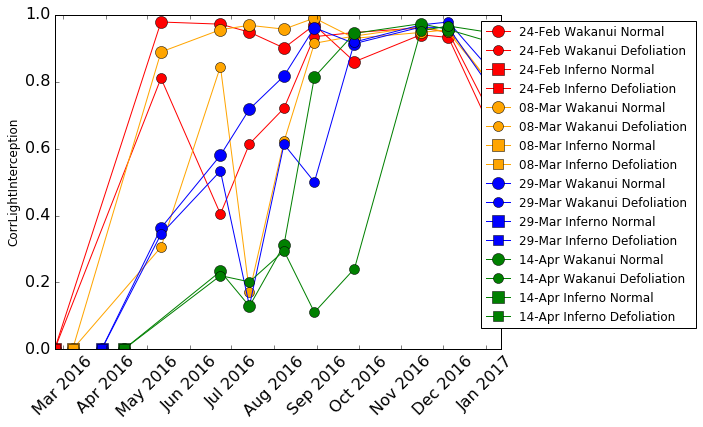

In [106]:
Year = 2016
Variable = 'CorrLightInterception'
MakeTimeCoarseGraph(Year,Variable)
plt.ylim(0,1)

(0, 1)

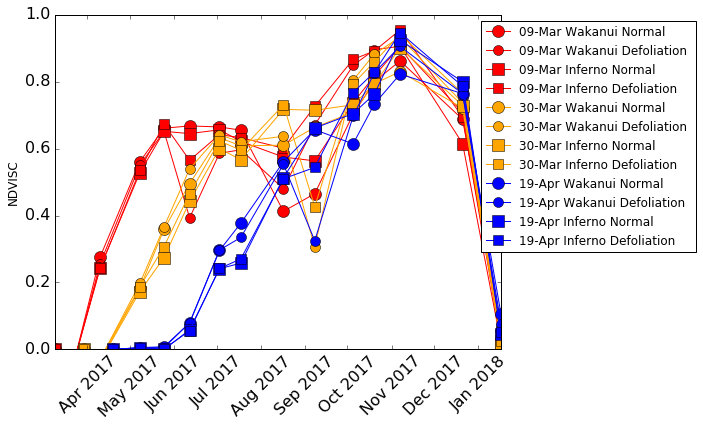

In [82]:
Year = 2017
Variable = 'NDVISC'
MakeTimeCoarseGraph(Year,Variable)
plt.ylim(0,1)

## Biomass model graph

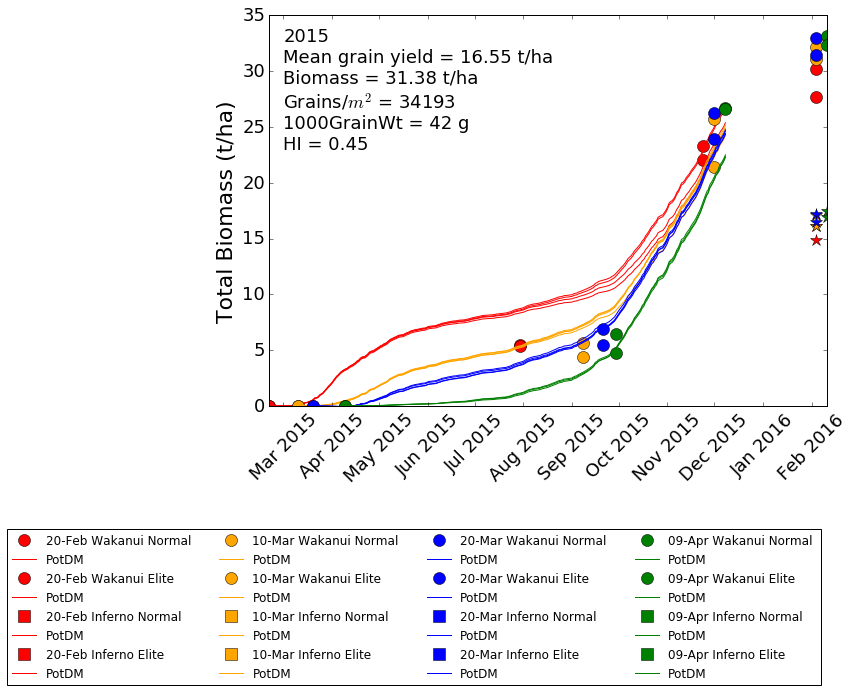

In [104]:
Year = 2015
GraphData = Data.ix[Data.YearSown==Year]
GraphTreats = MakeYearIndex(Year)
for var in GraphTreats.columns:
        LevelList = GraphTreats.ix[:,var].drop_duplicates().values
        if LevelList.size <= 1:
            GraphTreats.drop(var,axis=1,inplace=True)
Demarkers = SetSymbols(GraphTreats)
Graph = plt.figure(figsize=(10,7))

for Treat in GraphTreats.index:
    Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat) & (Data.Cultivar == 'Wakanui')
    GraphData = Data.ix[Filter,'TotalBiomass'].dropna().groupby(level='SampleDate').mean()/1000
    col = Demarkers[0][GraphTreats.ix[Treat][0]]
    mark = Demarkers[1][GraphTreats.ix[Treat][1]]
    plt.plot(GraphData,mark,color = col, markersize = 12,label = MakeLabel(GraphTreats.ix[Treat,:]))
    Potbiomass = BiomassAnalysis.ix[(Year,Treat),'PotDM'].cumsum()
    plt.plot(Potbiomass/1000,'-', color=col)
    try:
        YieldData = Data.ix[Filter,'Grain14Percent'].dropna().mean()/1000
        Date =  Data.ix[Filter,'Grain14Percent'].dropna().index[0]
        plt.plot(Date,YieldData,'*',color = col, markersize = 12)
    except:
        fail = 'yes'
MeanYield = Data.ix[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'Grain14Percent'].dropna().mean()/1000
MeanBiomass = Data.ix[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui')&(Data.SampleGS=='GS90'),'TotalBiomass'].dropna().mean()/1000
MeanGrainSize = IndexedData.ix[(IndexedData.YearSown == Year)&(IndexedData.Cultivar == 'Wakanui'),'1000GrainWt0Pc'].dropna().mean()
MeanGrainNumber = Data.ix[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'GrainsMSq'].dropna().mean()
MeanHI = Data.ix[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'HI'].dropna().mean()
PlotDate = dt.datetime(Year,03,01)
plt.text(PlotDate,23,str(Year)+'\nMean grain yield = '+'%.2f'%MeanYield + ' t/ha'+
         '\n'+ 'Biomass = ' + '%.2f'%MeanBiomass + ' t/ha' +
         '\n'+ r'Grains/$m^2$ = '+'%.0f'%MeanGrainNumber +
         '\n'+ '1000GrainWt = ' + '%.0f'%MeanGrainSize + ' g'+
         '\n'+ 'HI = '+ '%.2f'%MeanHI,fontsize=18)
plt.legend(bbox_to_anchor=(1, -0.3),numpoints=1,ncol=4)
plt.xticks(rotation=45)
plt.ylim(0,35)
plt.tick_params(labelsize=18)
plt.ylabel('Total Biomass (t/ha)',fontsize=22)

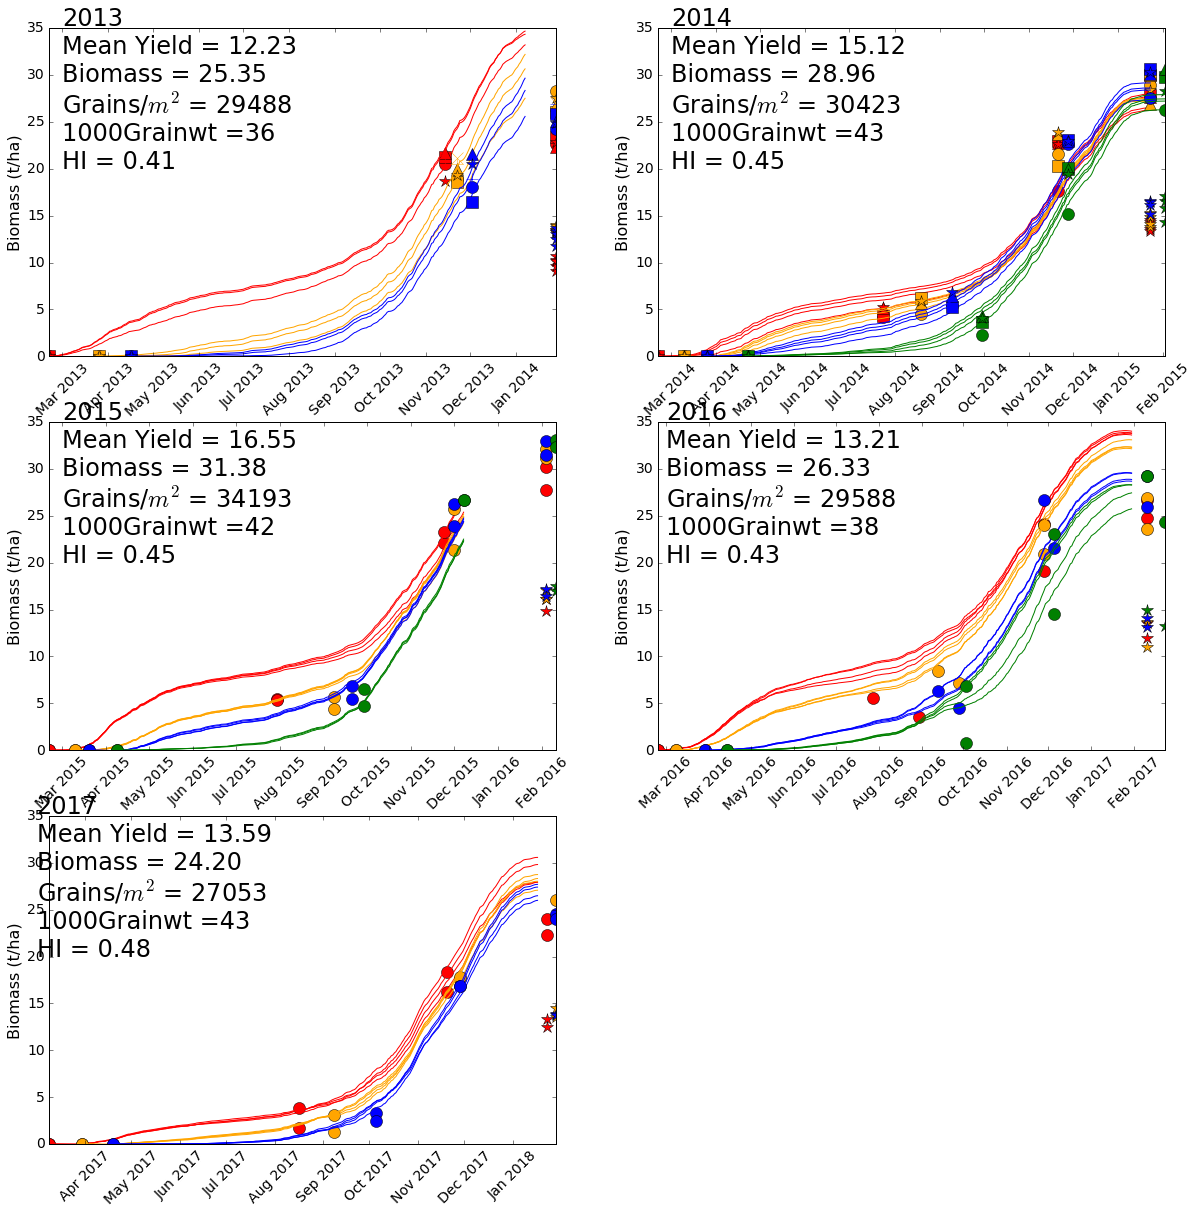

In [86]:
Graph = plt.figure(figsize=(20,20))
Pos =1
for Year in YearList:
    Graph.add_subplot(3,2,Pos)
    GraphData = Data.ix[Data.YearSown==Year]
    GraphTreats = MakeYearIndex(Year)
    for var in GraphTreats.columns:
        LevelList = GraphTreats.ix[:,var].drop_duplicates().values
        if LevelList.size <= 1:
            GraphTreats.drop(var,axis=1,inplace=True)
    Demarkers = SetSymbols(GraphTreats)
    for Treat in GraphTreats.index:
        Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat) & (Data.Cultivar == 'Wakanui')
        GraphData = Data.ix[Filter,'TotalBiomass'].dropna().groupby(level='SampleDate').mean()/1000
        col = Demarkers[0][GraphTreats.ix[Treat][0]]
        mark = Demarkers[1][GraphTreats.ix[Treat][1]]
        plt.plot(GraphData,mark,color = col, markersize = 12,label = MakeLabel(GraphTreats.ix[Treat,:]))
        Potbiomass = BiomassAnalysis.ix[(Year,Treat),'PotDM'].cumsum()
        plt.plot(Potbiomass/1000,'-', color=col)
        try:
            YieldData = Data.ix[Filter,'Grain14Percent'].dropna().mean()/1000
            Date =  Data.ix[Filter,'Grain14Percent'].dropna().index[0]
            plt.plot(Date,YieldData,'*',color = col, markersize = 12)
        except:
            fail = 'yes'
    MeanYield = Data.ix[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'Grain14Percent'].dropna().mean()/1000
    MeanBiomass = Data.ix[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui')&(Data.SampleGS=='GS90'),'TotalBiomass'].dropna().mean()/1000
    MeanGrainSize = IndexedData.ix[(IndexedData.YearSown == Year)&(IndexedData.Cultivar == 'Wakanui'),'1000GrainWt0Pc'].dropna().mean()
    MeanGrainNumber = Data.ix[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'GrainsMSq'].dropna().mean()
    MeanHI = Data.ix[(Data.YearSown == Year)&(Data.Cultivar == 'Wakanui'),'HI'].dropna().mean()
    PlotDate = dt.datetime(Year,03,01)
    plt.text(PlotDate,20,str(Year)+'\nMean Yield = '+'%.2f'%MeanYield +
             '\n'+ 'Biomass = ' + '%.2f'%MeanBiomass +
             '\n'+ r'Grains/$m^2$ = '+'%.0f'%MeanGrainNumber +
             '\n'+ '1000Grainwt =' + '%.0f'%MeanGrainSize +
             '\n'+ 'HI = '+ '%.2f'%MeanHI,fontsize=24)
    Pos +=1
    plt.xticks(rotation=45)
    plt.ylim(0,35)
    plt.tick_params(labelsize=14)
    plt.ylabel('Biomass (t/ha)',fontsize=16)

## Harvest Graph

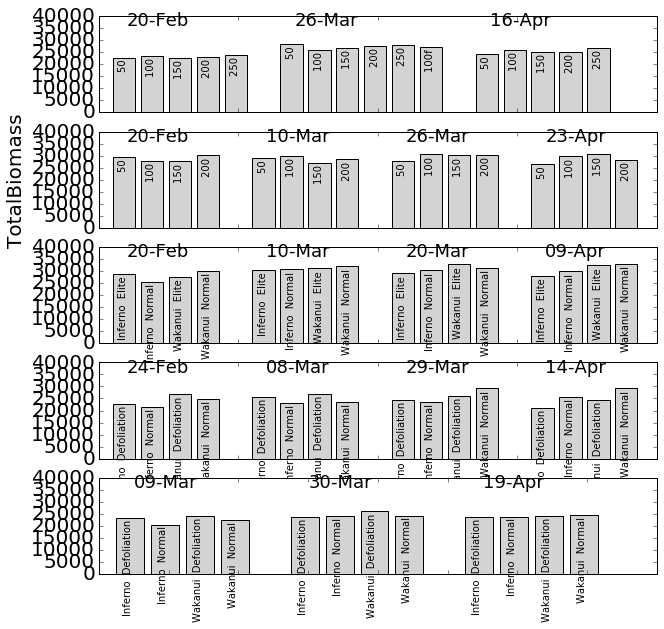

In [93]:
Variable = 'TotalBiomass'
MakeHarvestVariableGraph(Variable)

## Harvest correlations

In [94]:
['GrainsMSq','EarsMSq','StemsMSq','GrainsEar','1000GrainWt0Pc','GrainsPerGramStem',
 'TotalBiomass','HI','StemBiomass','StemBiomass','AnthesisBiomass','AnthesisStem']

['GrainsMSq',
 'EarsMSq',
 'StemsMSq',
 'GrainsEar',
 '1000GrainWt0Pc',
 'GrainsPerGramStem',
 'TotalBiomass',
 'HI',
 'StemBiomass',
 'StemBiomass',
 'AnthesisBiomass',
 'AnthesisStem']

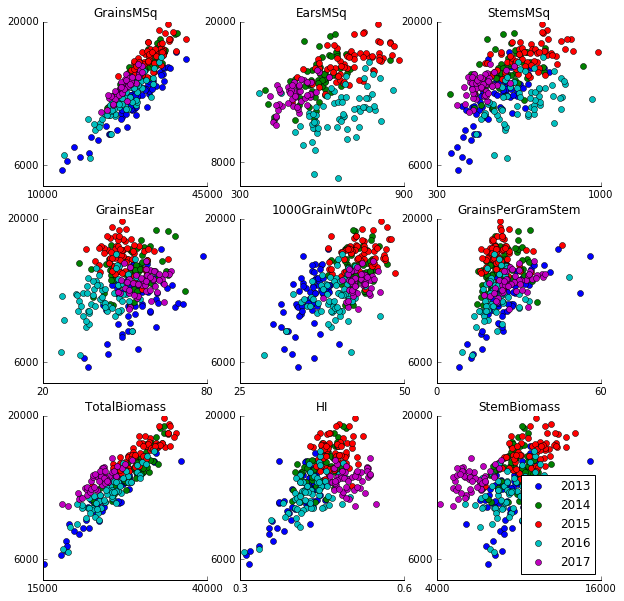

In [95]:
YVariable = 'Grain14Percent'
ComponentPairs = [['GrainsMSq',YVariable],
                  ['EarsMSq',YVariable],
                  ['StemsMSq',YVariable],
                  ['GrainsEar',YVariable],
                  ['1000GrainWt0Pc',YVariable],
                  ['GrainsPerGramStem',YVariable],
                  ['TotalBiomass',YVariable],
                  ['HI',YVariable],
                  ['StemBiomass',YVariable]]
Graph = plt.figure(figsize=(10,10))
pos = 1
for Component in ComponentPairs:
    Ax = Graph.add_subplot(3,3,pos)
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
    plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
    for Year in YearList:
        XData = IndexedData.ix[Year,Component[0]]
        YData = IndexedData.ix[Year,Component[1]]
        plt.plot(XData,YData,'o',label=Year)
        #plt.ylabel(Component[1])
        plt.title(Component[0])
    Ax.set_xticks([Ax.get_xticks()[0],Ax.get_xticks()[-1]])
    Ax.set_yticks([Ax.get_yticks()[1],Ax.get_yticks()[-1]])
    #Ax.set_xticklabels(['Less','More'])
    #Ax.set_yticklabels(['Modest','Jolly Good'])
    if pos == 9:
        plt.legend(loc=0,numpoints=1)
    pos+=1

## Met data variables

In [29]:
IndexedData.columns

Index([              u'TrialCode',                u'YearSown',
                        u'Farmer',                u'Location',
                          u'Plot',           u'TrialCodePlot',
                        u'TrtNum',                   u'Block',
                      u'Cultivar',              u'SowingDate',
                     u'PlantPopn',                  u'PGRTrt',
                     u'PGRTiming',        u'PGRCanopyMgmtTrt',
                          u'NTrt',              u'SampleDate',
                      u'ApproxGS',                u'SampleGS',
                u'ReassessmentGS',                u'PlantNum',
                       u'LeafNum',             u'NumLeafTips',
                    u'NumLigules',                   u'ttFeb',
                         u'ttMar',                   u'ttApr',
               u'LeafPositionNum',            u'LeafPosition',
                    u'AvLeafSize',            u'AvLeafWeight',
                         u'AvSLA',       u'PercentSenes

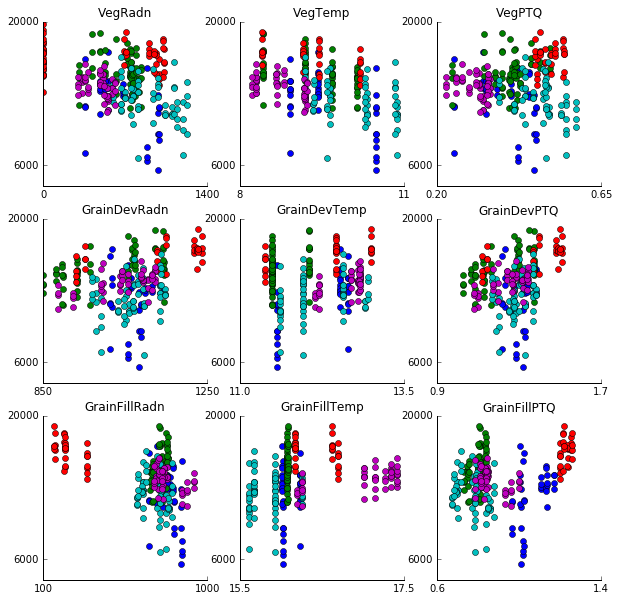

In [96]:
YVariable = 'Grain14Percent'
ComponentPairs = [['VegRadn',YVariable],
                  ['VegTemp',YVariable],
                  ['VegPTQ',YVariable],
                  ['GrainDevRadn',YVariable],
                  ['GrainDevTemp',YVariable],
                  ['GrainDevPTQ',YVariable],
                  ['GrainFillRadn',YVariable],
                  ['GrainFillTemp',YVariable],
                  ['GrainFillPTQ',YVariable]]
Graph = plt.figure(figsize=(10,10))
pos = 1
for Component in ComponentPairs:
    Ax = Graph.add_subplot(3,3,pos)
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
    plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
    for Year in YearList:
        XData = IndexedData.ix[Year,Component[0]]#.groupby(level='SowingDate').mean()
        YData = pd.to_numeric(IndexedData.ix[Year,Component[1]])#.groupby(level='SowingDate').mean()
        plt.plot(XData,YData,'o',label=Year)
        #plt.ylabel(Component[1])
        plt.title(Component[0])
    Ax.set_xticks([Ax.get_xticks()[0],Ax.get_xticks()[-1]])
    Ax.set_yticks([Ax.get_yticks()[1],Ax.get_yticks()[-1]])
#     if pos == 9:
#         plt.legend(loc=0,numpoints=1)
    pos+=1

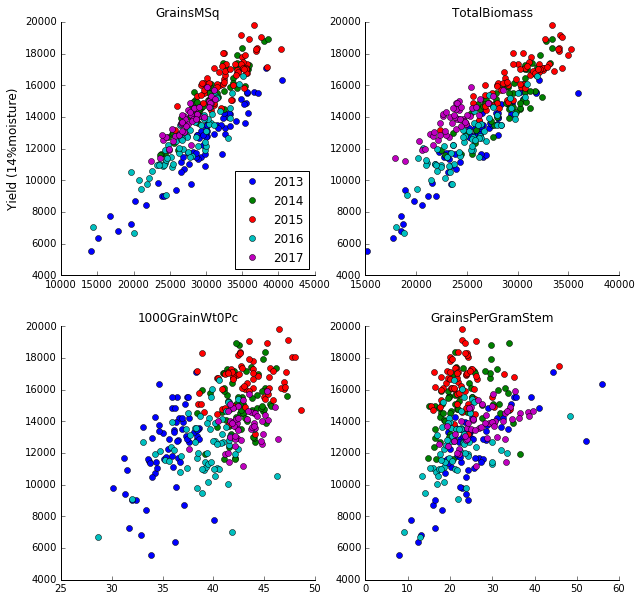

In [97]:
ComponentPairs = [['GrainsMSq','Grain14Percent'],
                  ['TotalBiomass','Grain14Percent'],
                  ['1000GrainWt0Pc','Grain14Percent'],
                 ['GrainsPerGramStem','Grain14Percent']]
Graph = plt.figure(figsize=(10,10))
pos = 1
for Component in ComponentPairs:
    Ax = Graph.add_subplot(2,2,pos)
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
    plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
    for Year in YearList:
        XData = IndexedData.ix[Year,Component[0]]
        YData = IndexedData.ix[Year,Component[1]]
        plt.plot(XData,YData,'o',label=Year)
        #plt.ylabel(Component[1])
        plt.title(Component[0])
    #Ax.set_xticks([Ax.get_xticks()[0],Ax.get_xticks()[-1]])
    #Ax.set_yticks([Ax.get_yticks()[1],Ax.get_yticks()[-1]])
    #Ax.set_xticklabels(['Less','More'])
    #Ax.set_yticklabels(['Modest','Jolly Good'])
    if pos == 1:
        plt.legend(loc=0,numpoints=1)
        plt.ylabel('Yield (14%moisture)',fontsize = 12)
    pos+=1

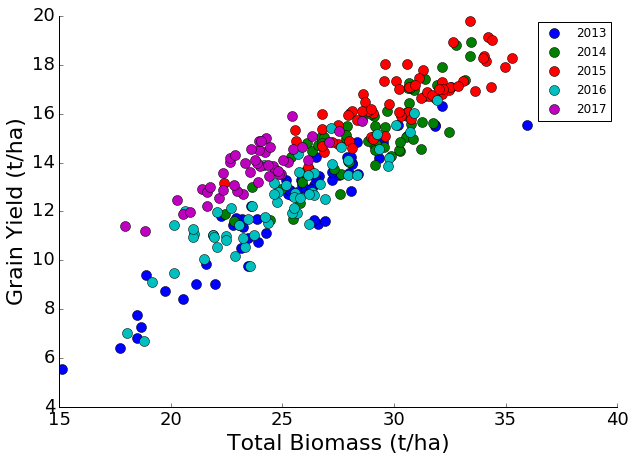

In [98]:
Graph = plt.figure(figsize=(10,7))
Ax = Graph.add_subplot(1,1,1)
Ax.spines['right'].set_visible(False)
Ax.spines['top'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
for Year in YearList:
    XData = IndexedData.ix[Year,'TotalBiomass']
    YData = IndexedData.ix[Year,'Grain14Percent']
    plt.plot(XData,YData,'o',label=Year,markersize = 10)
    #plt.ylabel(Component[1])
    #plt.title(Component[0])
plt.legend(loc=0,numpoints=1)
plt.ylabel('Grain Yield (t/ha)',fontsize = 22)
plt.xlabel('Total Biomass (t/ha)',fontsize = 22)
#plt.xlabel(r'$Grains /m^2$',fontsize = 22)
plt.tick_params(labelsize=18)
Ax.xaxis.set_ticklabels([15,20,25,30,35,40])
Ax.yaxis.set_ticklabels([4,6,8,10,12,14,16,18,20])

## Single variable Harvest correlations

In [99]:
'GrainsMSq','Grain14Percent','EarsMSq','StemsMSq','GrainsEar',
'ThousandGrainWeight','GrainsPerGramStem','TotalBiomass','HI','StemBiomass'

('ThousandGrainWeight',
 'GrainsPerGramStem',
 'TotalBiomass',
 'HI',
 'StemBiomass')

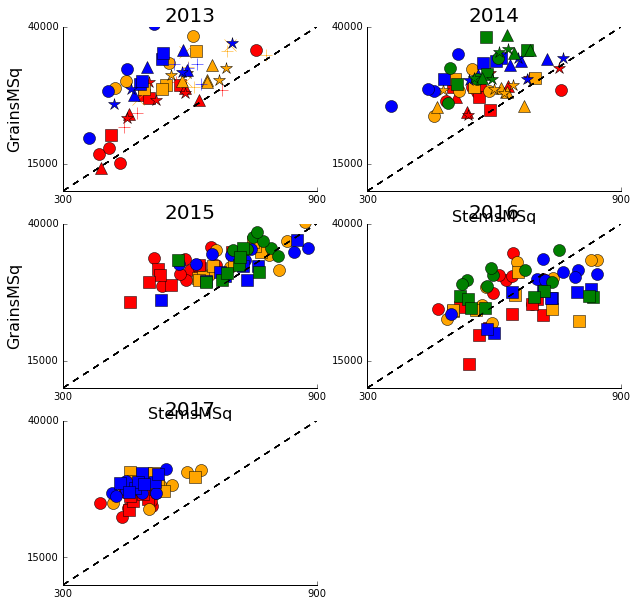

In [102]:
XVar = 'StemsMSq'
YVar = 'GrainsMSq'
MakeSingleVariableRegression(XVar,YVar)

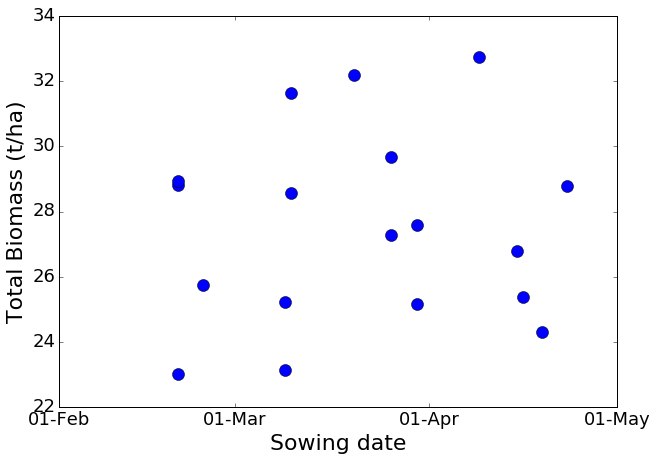

In [103]:
Graph = plt.figure(figsize=(10,7))
import matplotlib.dates as mdates

filter = (IndexedData.Cultivar == 'Wakanui') & (IndexedData.SampleGS=='GS90')
SowDateMeans = pd.DataFrame(IndexedData.ix[filter,'TotalBiomass'].groupby(level='SowingDate').mean())
SowDateMeans.ix[:,'SowJDay'] = [dt.datetime(2010,01,01) + (x - dt.datetime(x.year,01,01)) for x in SowDateMeans.index]
#SowDateMeans.index.strftime('%d-%b')
ax = Graph.add_subplot(1,1,1)
plt.plot(SowDateMeans.SowJDay,SowDateMeans.TotalBiomass,'o',markersize=12)
myFmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(myFmt)
plt.xlim('2010-02-01','2010-05-01')
ax.xaxis.set_ticks(['2010-02-01','2010-03-01','2010-04-01','2010-05-01'])
plt.ylabel('Total Biomass (t/ha)',fontsize=22)
plt.xlabel('Sowing date',fontsize=22)
plt.tick_params(labelsize=18)
ax.yaxis.set_ticklabels([22,24,26,28,30,32,34])

## Extract a subset of mean data and export

In [156]:
#List variables to export
Vars = ['SampleDate',
        'TotalBiomass',
        'Grain0Percent',
        'StrawBiomass',
        'StemBiomass',
        'EarBiomass',
        'ChaffBiomass',
        'TotalLeafBiomass',
        'GreenLeafBiomass',
        'DeadLeafBiomass',]
#Extrat these into a data frame and set sample date into the index
BaseData = IndexedData.ix[:,Vars].set_index('SampleDate',append=True)

#Get rid of non-numeric values
for Col in BaseData.columns:
    BaseData.ix[:,Col] = pd.to_numeric(BaseData.ix[:,Col])

#Group data to give means
ExportData = BaseData.groupby(level=['YearSown',
                                       'SowingDate',
                                       'Cultivar',
                                       'PlantPopn',
                                       'PGRCanopyMgmtTrt',
                                       'SampleDate']).mean().dropna(how='all')

# Remember to change the destination file!!!
ExportData.to_excel('K:\CPDiary\Data\FAR 20by2020\BiomassData.xlsx',sheet_name='BiomassData',merge_cells=False)

In [36]:
SowDate = 45
Ymax,TtSen,TtMat,Xo,b = 1.0,1500,2560,540,120
XTemp = [-10,0,15,25,35]
YRUE = [0,0,16,16,0]
HI = 0.55

PotYield = pd.read_csv('LincolnClean.met',sep='\t')
PotYield = PotYield.ix[SowDate:,:]
PotYield.set_index('Date', inplace=True)
PotYield.index = PotYield.index.to_datetime()
PotYield.ix[:,'MeanT'] = np.divide(np.add(PotYield.ix[:,'MinT'],PotYield.ix[:,'MaxT']),2)
PotYield.ix[:,'AccumTt'] = PotYield.ix[:,'MeanT'].cumsum()

PotYield.ix[:,'DAS'] = 0
for x in PotYield.ix[1:,:].index:
    if PotYield.ix[x,'Day']==SowDate:
        PotYield.ix[x,'DAS'] = 0
    else:
        PotYield.ix[x,'DAS'] = PotYield.ix[x-dt.timedelta(1),'DAS'] + 1

PotYield.ix[:,'SowDateTt'] = 0
for x in PotYield.ix[1:,:].index:
    if PotYield.ix[x,'Day']==SowDate:
        PotYield.ix[x,'SowDateTt'] = PotYield.ix[x,'AccumTt']
    else:
        PotYield.ix[x,'SowDateTt'] = PotYield.ix[x-dt.timedelta(1),'SowDateTt']

PotYield.ix[:,'Tt']= PotYield.ix[:,'AccumTt'] - PotYield.ix[:,'SowDateTt']

for date in PotYield.index:
    if PotYield.ix[date,'Tt'] < TtSen:
        PotYield.ix[date,'cover'] = Ymax/(1+np.exp(-(PotYield.ix[date,'Tt']-Xo)/b))
    else:
        if PotYield.ix[date,'Tt'] < TtMat:
            SenRate = Ymax/(TtMat - TtSen)
            PotYield.ix[date,'cover'] = Ymax-(PotYield.ix[date,'Tt'] - TtSen)*SenRate
        else:
            PotYield.ix[date,'cover'] = 0

PotYield.ix[:,'IntRadn'] = PotYield.ix[:,'cover'] * PotYield.ix[:,'Radn']
PotYield.ix[:,'RUE'] = [np.interp(PotYield.ix[x,'MeanT'],XTemp,YRUE) for x in PotYield.index]
PotYield.ix[:,'PotDM'] = PotYield.ix[:,'RUE'] * PotYield.ix[:,'IntRadn']

PotYield.ix[:,'PotBiomass'] = 0.0
for date in PotYield.ix[2:,:].index:
    if PotYield.ix[date,'cover'] == 0.0:
        PotYield.ix[date,'PotBiomass'] = 0
    else:
        PotYield.ix[date,'PotBiomass'] = PotYield.ix[date-dt.timedelta(1),'PotBiomass'] + PotYield.ix[date,'PotDM']

PotYield.ix[:,'PotYield'] = PotYield.ix[:,'PotBiomass'] * HI

Years = list(PotYield.Year.drop_duplicates())

AnnualYields = pd.DataFrame(index=Years,columns=['Yield'])

for year in Years:
    AnnualYields.ix[year,'Yield'] = PotYield.ix[PotYield.Year==year,'PotYield'].max()

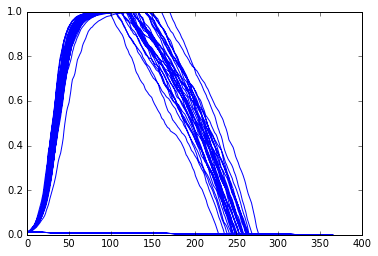

In [37]:
plt.plot(PotYield.DAS,PotYield.cover)

In [38]:
Median = PotYield.cover.groupby(by=PotYield.DAS).median()
Range = PotYield.cover.groupby(by=PotYield.DAS).sem()
Lower = Median - Range
Upper = Median + Range

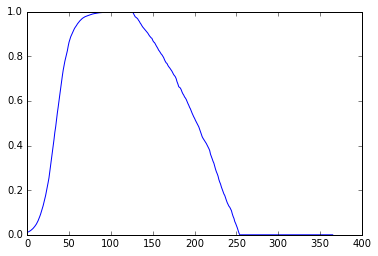

In [39]:
plt.plot(Median)

In [40]:
Year

2016

In [41]:
filter = IndexedData.SampleGS = 'GS90'
IndexedData.GS65.dropna()

YearSown  SowingDate  Cultivar  PlantPopn  PGRCanopyMgmtTrt
2013      2013-02-20  Wakanui   50         Normal             2013-11-16
                                           Normal             2013-11-16
                                           Normal             2013-11-16
                                           Normal             2013-11-16
                                           Normal             2013-11-16
                                           Normal             2013-11-16
                                           Normal             2013-11-16
                                           Normal             2013-11-16
                                           Normal             2013-11-16
                                           Normal             2013-11-16
                                           Normal             2013-11-16
                                           Normal             2013-11-16
                                           Normal             20

In [42]:
AnnualYields

,Yield
1986,7897.1
1987,6288.88
1988,6490.94
1989,7137.57
1990,7109.57
1991,7641.24
1992,8055.77
1993,7771.69
1994,7786.2
1995,7164.61


In [43]:
IndexedData.columns

Index([              u'TrialCode',                u'YearSown',
                        u'Farmer',                u'Location',
                          u'Plot',           u'TrialCodePlot',
                        u'TrtNum',                   u'Block',
                      u'Cultivar',              u'SowingDate',
                     u'PlantPopn',                  u'PGRTrt',
                     u'PGRTiming',        u'PGRCanopyMgmtTrt',
                          u'NTrt',              u'SampleDate',
                      u'ApproxGS',                u'SampleGS',
                u'ReassessmentGS',                u'PlantNum',
                       u'LeafNum',             u'NumLeafTips',
                    u'NumLigules',                   u'ttFeb',
                         u'ttMar',                   u'ttApr',
               u'LeafPositionNum',            u'LeafPosition',
                    u'AvLeafSize',            u'AvLeafWeight',
                         u'AvSLA',       u'PercentSenes

In [44]:
Index2 = ['YearSown','SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt','LeafPositionNum']
LeafSize = Data.set_index(Index2,drop=False)
Pair = Data.columns.isin(['AvLeafSize','LeafPositionNum','YearSown','SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt','AvLeafSize']
                         ])
LeafSizeData = LeafSize.ix[:,Pair]

SyntaxError: invalid syntax (<ipython-input-44-7ea849da15e7>, line 4)

In [ ]:
Test = Data.ix[:,['YearSown','SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt','LeafPositionNum','AvLeafSize']].dropna()
Test.ix[:,'LeafPos'] = Test.ix[:,'LeafPositionNum'].astype(np.int64)
Test.set_index(['YearSown','SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt','LeafPos'],inplace=True)

In [ ]:
Test.groupby(level='LeafPos').mean()

In [ ]:
Filter = (Data.YearSown == Year) & (Data.SowingDate == Treat) \
& (Data.Cultivar == 'Wakanui')  \
& ((Data.PlantPopn==200) | (Data.PlantPopn==50)) \
& (Data.PGRCanopyMgmtTrt == 'Normal')
Set = Data.columns.isin(['AvLeafSize','LeafPositionNum'])
Test = Data.ix[Filter,Set].dropna()
Test.set_index(['LeafPositionNum'],inplace=True)
Test.index.values.astype(np.int64)

In [ ]:
Data.ix[:,'LeafPositionNum'].dropna().astype(np.int64)

In [ ]:
Filter = (LeafSizeData.YearSown == Year) & (LeafSizeData.SowingDate == Treat) \
& (LeafSizeData.Cultivar == 'Wakanui')  \
& ((LeafSizeData.PlantPopn==200) | (LeafSizeData.PlantPopn==50)) \
& (LeafSizeData.PGRCanopyMgmtTrt == 'Normal')
LeafSizeData.ix[Filter,['AvLeafSize','LeafPositionNum']].values#.groupby(by=['LeafPositionNum'],axis=1).mean()

In [ ]:
Colors = ['red','orange','blue','green']
Markers = ['o-','s-','^-','*-']
Sizes = [12,10,8,6,4,2]
Graph = plt.figure(figsize=(8,6))
YearPos = 0
for Year in YearList:
    filter = Data.ix[:,'YearSown'] == Year
    SowDates = pd.to_datetime(Data.ix[filter,'SowingDate'].drop_duplicates().values)
    TreatPos = 0
    for Treat in SowDates:
        Filter = (Data.YearSown == Year) & (Data.SowingDate == Treat) & (Data.Cultivar == 'Wakanui')  & ((Data.PlantPopn==200) | (Data.PlantPopn==50)) & (Data.PGRCanopyMgmtTrt == 'Normal')
        GraphData = pd.to_numeric(LeafSizeData.ix[Filter,'AvLeafSize'].dropna()).groupby(level='LeafPositionNum').mean()
        XVar = pd.to_numeric(LeafSizeData.ix[Filter,'LeafPositionNum'].ix[GraphData.index].dropna()).groupby(level='LeafPositionNum').mean()
        plt.plot(XVar,GraphData,Markers[YearPos],color = Colors[TreatPos], markersize = 8,label = str(Treat.day)+'-'+str(Treat.month)+'-'+str(Treat.year))
        TreatPos +=1
    YearPos+=1
plt.xticks(rotation=45)
plt.ylabel('LeafTips',fontsize=12)
plt.xlabel('Tt from sowing')
plt.tick_params(labelsize=16)
plt.legend(bbox_to_anchor=(1.45, 1),numpoints=1)

In [ ]:
Data#.ix[:,'LeafPositionNum'].dropna()